전력사용량 예측 경진대회

# Business Understand

**평가 기준**

|항목|심사기준|점수|
|---|---|---|
|데이터|타당한 데이터 분석 기법 및 기준을 통해 분석했는가?|10|
|시각화|의도를 직관적으로 전달하는 시각화인가? |10|
|코드 품질|코드의 오류 없이 간결한 코드를 작성하였는가? |5|
|분석 방법|문제 해결을 위한 논리적인 구조가 명확한가? |10|
|성능|코드를 통해 전력산출량을 정확히 예측할 수 있는가? |30|
|관점|다른 사람이 생각하지 못한 새로운 관점을 제시하였는가? |10|
|인사이트|전력 융합신서비스 발굴 및 비즈니스 모델 개발 활용에 도움이 될 인사이트를 발굴하였는가? |25|

**논리성의 성능은 참가자가 게재한 코드의 구현 성능을 기준으로 함**

**평가 산식: SMAPE**
- Symmetric Mean Absolute Percentage Error
- MAPE의 경우  Actual 값이 0이거나 작은 경우 MAPE값이 지나치게 커지는 문제 발생
- SMAPE는 이를 개선

In [48]:
from IPython.display import Image
Image(url='https://wikimedia.org/api/rest_v1/media/math/render/svg/d1bfa1853da325fa525c67f48939e9131aad5700',
      width=300,
     )

In [50]:
Image(url='https://wikimedia.org/api/rest_v1/media/math/render/svg/9d7003eba8a7ffe2379cd5c232adf78daa3d1edf',
      width=300,
     )

In [35]:
def MAE(true, pred): # Mean Absolute Error
    '''
    true: np.array 
    pred: np.array
    '''
    return np.mean(np.abs(true-pred))

def MAPE(true, pred): # Mean Absolute Percentage Error
    '''
    true: np.array 
    pred: np.array
    '''
    return np.mean(np.abs((true-pred)/true))

def SMAPE(true, pred): # Symmetric Mean Absolute Percentage Error
    '''
    true: np.array 
    pred: np.array
    '''
    return np.mean((np.abs(true-pred))/(np.abs(true) + np.abs(pred))) #100은 상수이므로 이번 코드에서는 제외

TRUE_UNDER = np.array([10, 20, 30, 40, 50])
PRED_OVER = np.array([30, 40, 50, 60, 70])
TRUE_OVER = np.array([30, 40, 50, 60, 70])
PRED_UNDER = np.array([10, 20, 30, 40, 50])


print('평균 오차가 20일 때 실제값과 예측값의 대소 관계에 따른 MAE, MAPE 비교 \n')

print('실제값이 예측값 보다 작을 때 (예측값이 과대추정)')
print('MAE:', MAE(TRUE_UNDER, PRED_OVER))
print('MAPE:', MAPE(TRUE_UNDER, PRED_OVER))
print('SMAPE:', SMAPE(TRUE_UNDER, PRED_OVER))


print('\n실제값이 예측값 보다 클 때 (예측값이 과소추정)')
print('MAE:', MAE(TRUE_OVER, PRED_UNDER))
print('MAPE:', MAPE(TRUE_OVER, PRED_UNDER))
print('SMAPE:', SMAPE(TRUE_OVER, PRED_UNDER))

평균 오차가 20일 때 실제값과 예측값의 대소 관계에 따른 MAE, MAPE 비교 

실제값이 예측값 보다 작을 때 (예측값이 과대추정)
MAE: 20.0
MAPE: 0.9133333333333333
SMAPE: 0.29

실제값이 예측값 보다 클 때 (예측값이 과소추정)
MAE: 20.0
MAPE: 0.4371428571428571
SMAPE: 0.29


하지만 **SMAPE는 분모에 예측값 y^i이 들어가서 y^i에 의존적인 특성**을 지니고 있습니다. 예측값이 과소추정할 때 분모가 더 작아지므로 계산되는 오차가 커지는 현상이 발생합니다. 아래 코드를 통해 확인해보겠습니다.

In [38]:
TRUE2 = np.array([40, 50, 60, 70, 80])
PRED2_UNDER = np.array([20, 30, 40, 50, 60])
PRED2_OVER = np.array([60, 70, 80, 90, 100])

print('평균 오차가 20일 때 과소추정, 과대추정에 따른 MAE, SMAPE 비교 \n')

print('과대추정 시')
print('MAE:', MAE(TRUE2, PRED2_OVER))
print('MAPE:', MAPE(TRUE2, PRED2_OVER))
print('SMAPE:', SMAPE(TRUE2, PRED2_OVER))

print('\n과소추정 시')
print('MAE:', MAE(TRUE2, PRED2_UNDER))
print('MAPE:', MAPE(TRUE2, PRED2_UNDER))
print('SMAPE:', SMAPE(TRUE2, PRED2_UNDER))

평균 오차가 20일 때 과소추정, 과대추정에 따른 MAE, SMAPE 비교 

과대추정 시
MAE: 20.0
MAPE: 0.3538095238095238
SMAPE: 0.14912698412698414

과소추정 시
MAE: 20.0
MAPE: 0.3538095238095238
SMAPE: 0.21857142857142856


**외부 데이터 및 사전 학습 모델**
- 평가 데이터 셋 이전 기간 **(2020년 8월 25일 전)** 의 외부 데이터 사용 가능
- 공공 데이터 및 법적 제약이 없는 외부 데이터 허용
- 사전학습 모델의 경우 사전학습에 사용된 데이터를 명시

# Data Understanding

**train.csv:**
- 60개 건물들의 2020년 6월 1일부터 2020년 8월 24일까지의 데이터
- 1시간 단위로 제공
- 전력사용량(kWh) 포함
- shape: (122400, 10)

**test.csv:**
- 60개 건물들의 2020년 8월 25일부터 2020년 8월 31일까지의 데이터
- 3시간 단위로 제공(강수량의 경우 6시간 단위로 제공, 예보데이터)
- 전력사용량(kWh) 미포함
- shape: (10080, 9)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
PATH = r'C:\Users\Wyatt\wyatt37\data\energy'

In [52]:
train_col = ['num', 'date_time', 'target', 'temp', 'wind', 'humid', 'rain', 'sunny', 'cooler', 'solar']
test_col = ['num', 'date_time', 'temp', 'wind', 'humid', 'rain', 'sunny', 'cooler', 'solar']

In [141]:
train = pd.read_csv(PATH + '\\train.csv', encoding='cp949', names=train_col, header=0)
train

,num,date_time,target,temp,wind,humid,rain,sunny,cooler,solar
0,1,2020-06-01 00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0
1,1,2020-06-01 01,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0
2,1,2020-06-01 02,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0
3,1,2020-06-01 03,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0
4,1,2020-06-01 04,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
122395,60,2020-08-24 19,4114.368,27.8,2.3,68.0,0.0,0.7,1.0,1.0
122396,60,2020-08-24 20,3975.696,27.3,1.2,71.0,0.0,0.0,1.0,1.0
122397,60,2020-08-24 21,3572.208,27.3,1.8,71.0,0.0,0.0,1.0,1.0
122398,60,2020-08-24 22,3299.184,27.1,1.8,74.0,0.0,0.0,1.0,1.0


In [64]:
test = pd.read_csv(PATH + '\\test.csv', encoding='cp949', names=test_col, header=0)
test

,num,date_time,temp,wind,humid,rain,sunny,cooler,solar
0,1,2020-08-25 00,27.8,1.5,74.0,0.0,0.0,NaN,NaN
1,1,2020-08-25 01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2020-08-25 02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,2020-08-25 03,27.3,1.1,78.0,NaN,0.0,NaN,NaN
4,1,2020-08-25 04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
10075,60,2020-08-31 19,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10076,60,2020-08-31 20,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10077,60,2020-08-31 21,27.9,4.1,68.0,NaN,0.0,1.0,1.0
10078,60,2020-08-31 22,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [65]:
sub = pd.read_csv(PATH + '\\sample_submission.csv', encoding='cp949')
sub

,num_date_time,answer
0,1 2020-08-25 00,0
1,1 2020-08-25 01,0
2,1 2020-08-25 02,0
3,1 2020-08-25 03,0
4,1 2020-08-25 04,0
...,...,...
10075,60 2020-08-31 19,0
10076,60 2020-08-31 20,0
10077,60 2020-08-31 21,0
10078,60 2020-08-31 22,0


In [66]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122400 entries, 0 to 122399
Data columns (total 10 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   num        122400 non-null  int64  
 1   date_time  122400 non-null  object 
 2   target     122400 non-null  float64
 3   temp       122400 non-null  float64
 4   wind       122400 non-null  float64
 5   humid      122400 non-null  float64
 6   rain       122400 non-null  float64
 7   sunny      122400 non-null  float64
 8   cooler     122400 non-null  float64
 9   solar      122400 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 9.3+ MB


In [67]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10080 entries, 0 to 10079
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   num        10080 non-null  int64  
 1   date_time  10080 non-null  object 
 2   temp       3360 non-null   float64
 3   wind       3360 non-null   float64
 4   humid      3360 non-null   float64
 5   rain       1680 non-null   float64
 6   sunny      3360 non-null   float64
 7   cooler     2296 non-null   float64
 8   solar      1624 non-null   float64
dtypes: float64(7), int64(1), object(1)
memory usage: 708.9+ KB


In [68]:
test.head(10)

,num,date_time,temp,wind,humid,rain,sunny,cooler,solar
0,1,2020-08-25 00,27.8,1.5,74.0,0.0,0.0,NaN,NaN
1,1,2020-08-25 01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2020-08-25 02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,2020-08-25 03,27.3,1.1,78.0,NaN,0.0,NaN,NaN
4,1,2020-08-25 04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1,2020-08-25 05,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1,2020-08-25 06,26.1,1.3,83.0,0.0,0.0,NaN,NaN
7,1,2020-08-25 07,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1,2020-08-25 08,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1,2020-08-25 09,28.8,1.2,77.0,NaN,1.1,NaN,NaN


In [69]:
sub

,num_date_time,answer
0,1 2020-08-25 00,0
1,1 2020-08-25 01,0
2,1 2020-08-25 02,0
3,1 2020-08-25 03,0
4,1 2020-08-25 04,0
...,...,...
10075,60 2020-08-31 19,0
10076,60 2020-08-31 20,0
10077,60 2020-08-31 21,0
10078,60 2020-08-31 22,0


In [70]:
train

,num,date_time,target,temp,wind,humid,rain,sunny,cooler,solar
0,1,2020-06-01 00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0
1,1,2020-06-01 01,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0
2,1,2020-06-01 02,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0
3,1,2020-06-01 03,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0
4,1,2020-06-01 04,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
122395,60,2020-08-24 19,4114.368,27.8,2.3,68.0,0.0,0.7,1.0,1.0
122396,60,2020-08-24 20,3975.696,27.3,1.2,71.0,0.0,0.0,1.0,1.0
122397,60,2020-08-24 21,3572.208,27.3,1.8,71.0,0.0,0.0,1.0,1.0
122398,60,2020-08-24 22,3299.184,27.1,1.8,74.0,0.0,0.0,1.0,1.0


In [142]:
train['datetime'] = pd.to_datetime(train.date_time)

train['month'] = train.datetime.dt.month                    # 월(숫자)
train['day'] = train.datetime.dt.day                        # 일(숫자)
train['hour'] = train.datetime.dt.hour                      # 시(숫자)
train['weekday'] = train.datetime.dt.weekday                # 시(숫자)
train['dayofyear'] = train.datetime.dt.dayofyear            # 연 기준 몇일째(숫자)
train['weekofyear'] = train.datetime.dt.isocalendar().week  # 연 기준 몇주째(숫자) (=week)

In [143]:
train.drop(['date_time', 'datetime'], axis=1, inplace=True)

In [144]:
train

,num,target,temp,wind,humid,rain,sunny,cooler,solar,month,day,hour,weekday,dayofyear,weekofyear
0,1,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0,6,1,0,0,153,23
1,1,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0,6,1,1,0,153,23
2,1,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0,6,1,2,0,153,23
3,1,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0,6,1,3,0,153,23
4,1,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0,6,1,4,0,153,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122395,60,4114.368,27.8,2.3,68.0,0.0,0.7,1.0,1.0,8,24,19,0,237,35
122396,60,3975.696,27.3,1.2,71.0,0.0,0.0,1.0,1.0,8,24,20,0,237,35
122397,60,3572.208,27.3,1.8,71.0,0.0,0.0,1.0,1.0,8,24,21,0,237,35
122398,60,3299.184,27.1,1.8,74.0,0.0,0.0,1.0,1.0,8,24,22,0,237,35


## EDA

<AxesSubplot:xlabel='day', ylabel='target'>

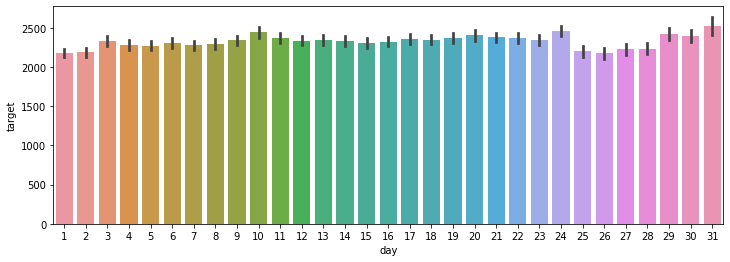

In [145]:
plt.figure(figsize=(12, 4))
sns.barplot(data=train, x='day', y='target')

<AxesSubplot:xlabel='dayofyear', ylabel='target'>

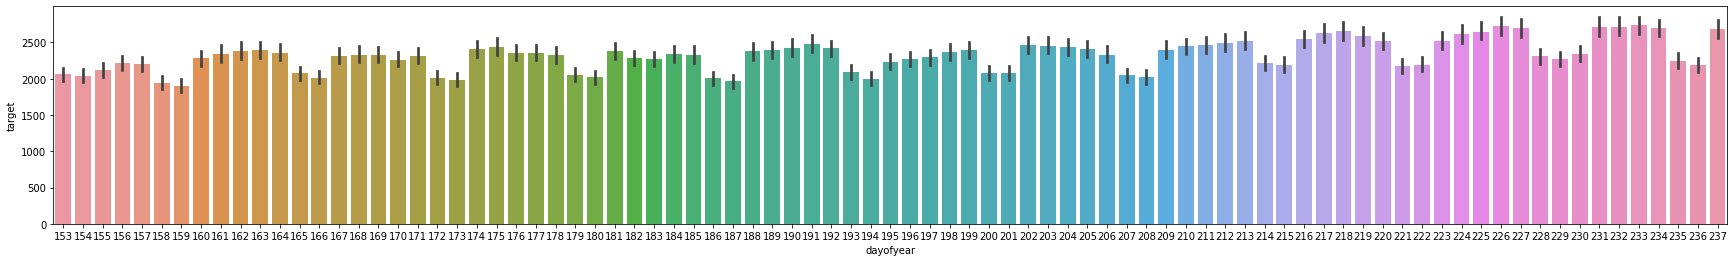

In [148]:
plt.figure(figsize=(30, 4))
sns.barplot(data=train, x='dayofyear', y='target')

<AxesSubplot:xlabel='hour', ylabel='target'>

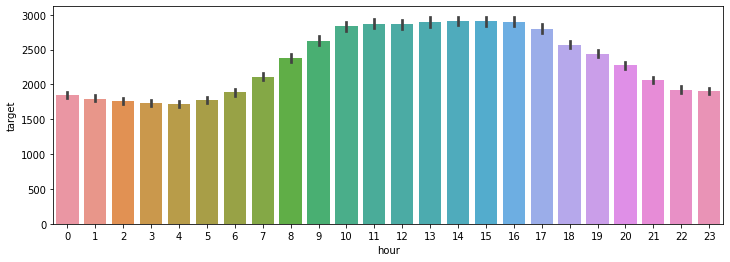

In [136]:
plt.figure(figsize=(12, 4))
sns.barplot(data=train, x='hour', y='target')

<AxesSubplot:xlabel='num', ylabel='target'>

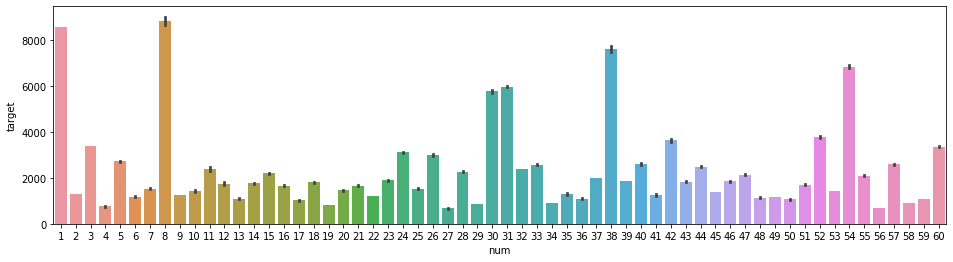

In [149]:
plt.figure(figsize=(16, 4))
sns.barplot(data=train, x='num', y='target')

<AxesSubplot:xlabel='weekday', ylabel='target'>

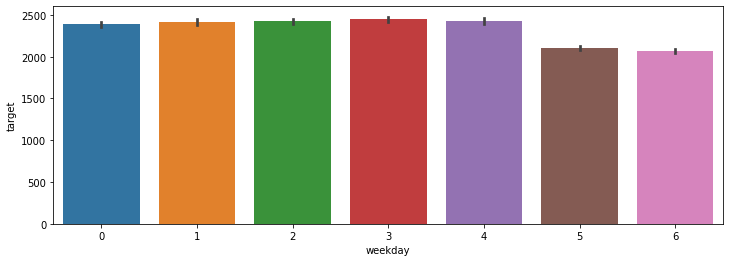

In [138]:
plt.figure(figsize=(12, 4))
sns.barplot(data=train, x='weekday', y='target')

<AxesSubplot:xlabel='month', ylabel='target'>

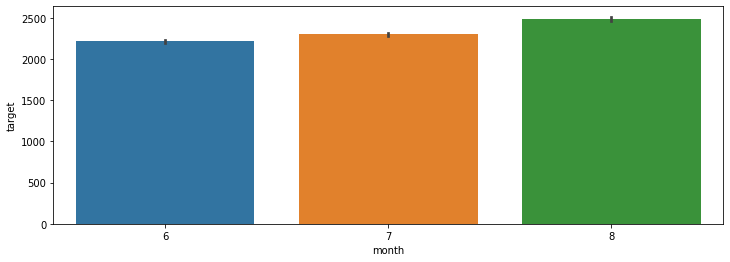

In [139]:
plt.figure(figsize=(12, 4))
sns.barplot(data=train, x='month', y='target')

<AxesSubplot:xlabel='weekofyear', ylabel='target'>

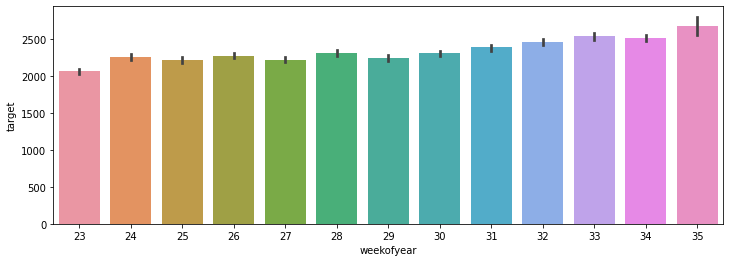

In [140]:
plt.figure(figsize=(12, 4))
sns.barplot(data=train, x='weekofyear', y='target')

### dayofyear

<AxesSubplot:xlabel='dayofyear', ylabel='target'>

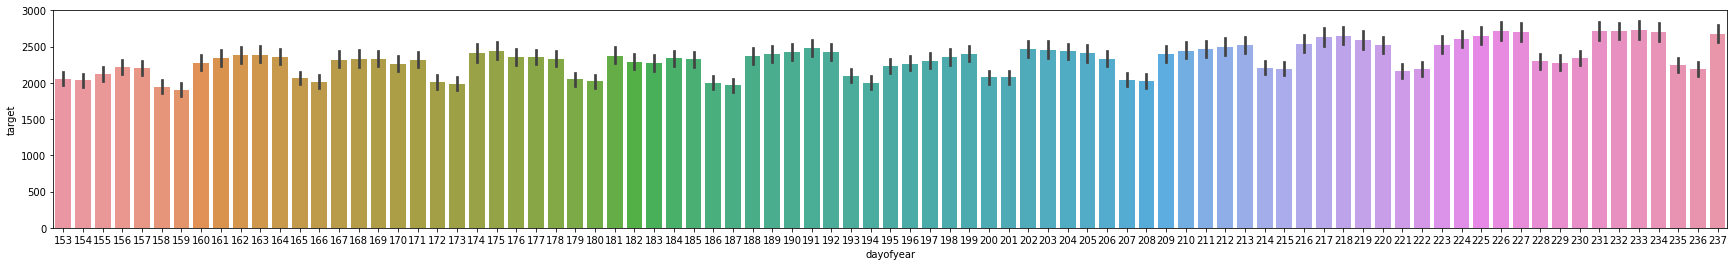

In [157]:
plt.figure(figsize=(30, 4))
sns.barplot(data=train, x='dayofyear', y='target')

<AxesSubplot:xlabel='dayofyear', ylabel='temp'>

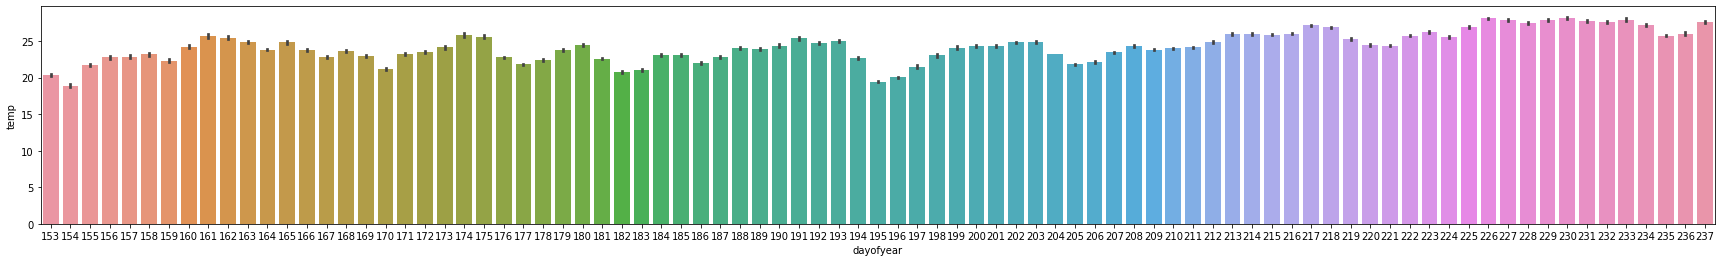

In [151]:
plt.figure(figsize=(30, 4))
sns.barplot(data=train, x='dayofyear', y='temp')

<AxesSubplot:xlabel='dayofyear', ylabel='wind'>

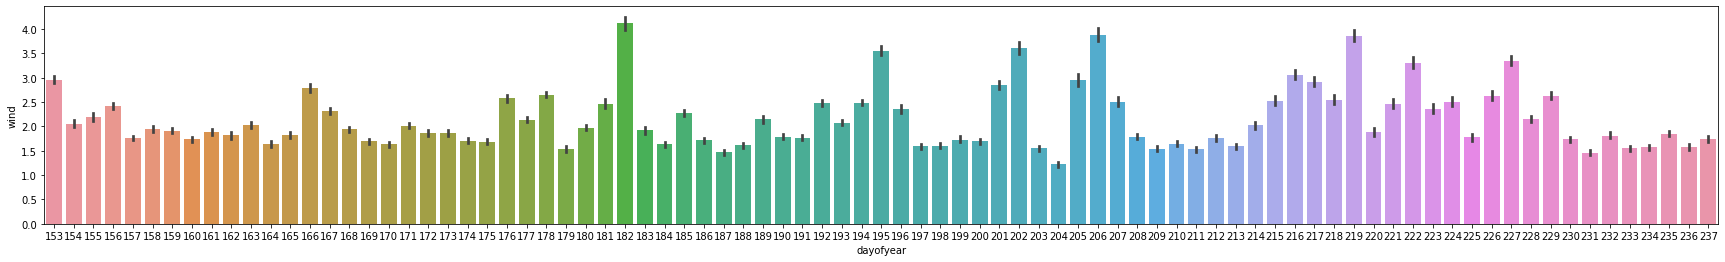

In [152]:
plt.figure(figsize=(30, 4))
sns.barplot(data=train, x='dayofyear', y='wind')

<AxesSubplot:xlabel='dayofyear', ylabel='humid'>

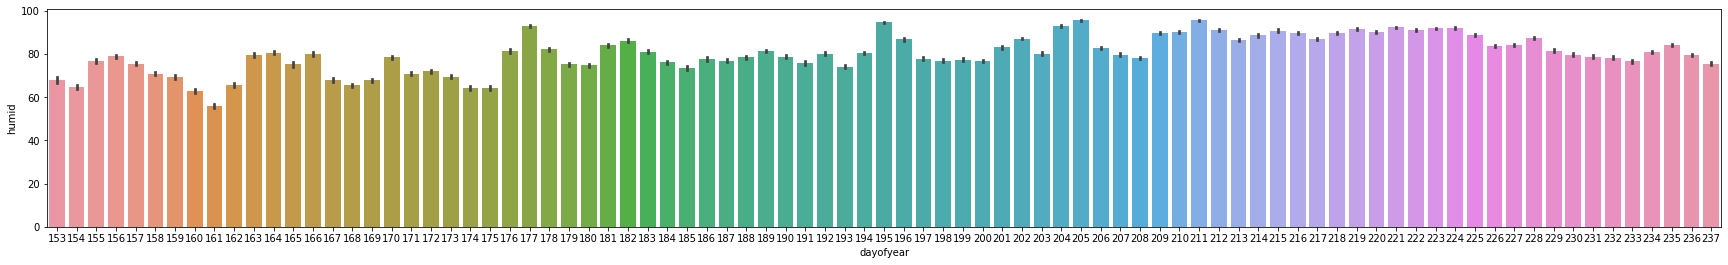

In [153]:
plt.figure(figsize=(30, 4))
sns.barplot(data=train, x='dayofyear', y='humid')

<AxesSubplot:xlabel='dayofyear', ylabel='sunny'>

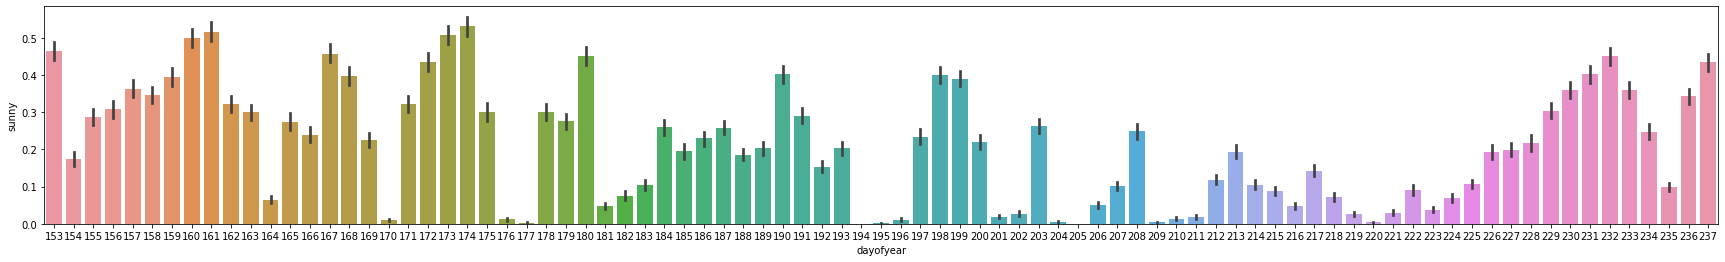

In [158]:
plt.figure(figsize=(30, 4))
sns.barplot(data=train, x='dayofyear', y='sunny')